In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [4]:
!nvidia-smi

Thu Jan 13 03:49:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Installing important libraries:**


In [5]:
!pip install utils
!pip install tensorpack

     |████████████████████████████████| 296 kB 7.2 MB/s 


**Importing the dataset**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile
import random
import tensorflow as tf
import numpy as np
np.random.seed(456)
import shutil
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from glob import glob

In [8]:
for element in glob("/content/drive/MyDrive/imagedata/yes/*.jpg"):
  shutil.copy(element,"/content/yes/")
for element in glob("/content/drive/MyDrive/imagedata/no/*.jpg"):
  shutil.copy(element,"/content/no/")

In [9]:
len1 = os.listdir("/content/yes/")
len2 = os.listdir("/content/no/")
print(len(len1))
print(len(len2))

86
85


**Data Augmnentation**

In [10]:
from tensorflow.keras.initializers import VarianceScaling
#kernel_initializer = tf.contrib.layers.variance_scaling_initializer(2.0)
kernel_initializer = tf.keras.initializers.VarianceScaling(2.0) #https://www.tensorflow.org/api_docs/python/tf/keras/initializers/VarianceScaling

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    
import os
from PIL import Image
%matplotlib inline

In [12]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [17]:
start_time = time.time()

augmented_data_path = '/content/augmented data/'

# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir='/content/yes/', n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir='/content/no/', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:1:11.1


In [15]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

In [18]:
data_summary(augmented_data_path)

Number of examples: 2904
Percentage of positive examples: 41.460055096418735%, number of pos examples: 1204
Percentage of negative examples: 58.539944903581265%, number of neg examples: 1700


**Model architecture creation**

In [19]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dropout
import math
from typing import Iterator, List, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
### Import necessary dependencies and libraries
import tensorflow as tf
from tensorpack.models.common import layer_register
from tensorpack.utils.argtools import shape2d, shape4d, get_data_format
from tensorpack.models import BatchNorm, BNReLU, Conv2D
import math
import utils
import random
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorpack.models.common import layer_register, VariableHolder
from tensorpack.tfutils.common import get_tf_version_tuple
#from tensorflow.contrib.framework.python.ops import add_arg_scope
from tensorpack.tfutils.tower import get_current_tower_context
from tensorpack.utils.argtools import shape2d, shape4d, get_data_format
from tensorpack.models.tflayer import rename_get_variable, convert_to_tflayer_args
from tensorpack.models import BatchNorm, BNReLU, Conv2D
import numpy as np
import math
import utils
import os

In [20]:
IMAGE_SIZE = [224, 224]
model = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# layer = Dropout(0.9)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# new_model = Sequential()
# new_model.add(model)
# new_model.add(layer)

In [ ]:
# new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
Total params: 3,228,864
Trainable params: 3,206,976
Non-trainable params: 21,888
_________________________________________________________________


In [21]:
x = Flatten()(model.output)
prediction = Dense(3, activation='softmax')(x)
model_finall = Model(inputs=model.input, outputs=prediction)
model_finall.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [22]:
model_finall.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

**Distributing the data into train test and validation set**

In [23]:
all_pathsHEALTH = []
from glob import glob
N=0
for element in glob("augmented data/yes/*"): 
  all_pathsHEALTH.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items = random.sample(all_pathsHEALTH, num_to_select)
for element in list_of_random_items:
  p = element.split("/") 
  os.replace(element, "val/yes/"+p[-1])

In [24]:
all_pathsHEALTH = []
from glob import glob
N=0
for element in glob("augmented data/no/*"): 
  all_pathsHEALTH.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items = random.sample(all_pathsHEALTH, num_to_select)
for element in list_of_random_items:
  p = element.split("/") 
  os.replace(element, "val/no/"+p[-1])

In [25]:
all_pathsHEALTH = []
from glob import glob
N=0
for element in glob("augmented data/yes/*"): 
  all_pathsHEALTH.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items = random.sample(all_pathsHEALTH, num_to_select)
for element in list_of_random_items:
  p = element.split("/") 
  os.replace(element, "test/yes/"+p[-1])

In [26]:
all_pathsHEALTH = []
from glob import glob
N=0
for element in glob("augmented data/no/*"): 
  all_pathsHEALTH.append(element) #append individual paths of renamed Training Images in all_paths list
  #clahe_resize(element) #resize the pictures
  N+=1
num_to_select = int(round(N*0.10))          #select 10% of training images these many pictures from all_paths at random               
list_of_random_items = random.sample(all_pathsHEALTH, num_to_select)
for element in list_of_random_items:
  p = element.split("/") 
  os.replace(element, "test/no/"+p[-1])

In [27]:
sum_train = len(os.listdir("augmented data/yes/"))+len(os.listdir("augmented data/no/"))
sum_val = len(os.listdir("val/yes/"))+len(os.listdir("val/no/"))
sum_test = len(os.listdir("test/yes/"))+len(os.listdir("test/no/"))
print(f"Images in Train = {sum_train}")
print(f"Images in Validation = {sum_val}")
print(f"Images in Test = {sum_test}")

Images in Train = 2353
Images in Validation = 290
Images in Test = 261


In [28]:
import zipfile
import random
import tensorflow as tf
import numpy as np
np.random.seed(456)
import shutil
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
train_path ='/content/augmented data/'
train_datagen = ImageDataGenerator(rescale= 1./255)
train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    target_size=(224, 224)
)


val_path = '/content/val/'
val_datagen = ImageDataGenerator(rescale= 1./255)
val_generator = val_datagen.flow_from_directory(
    val_path,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    target_size=(224, 224)
)


test_path = '/content/test/'
test_datagen = ImageDataGenerator(rescale= 1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    target_size=(224, 224)
)

Found 2353 images belonging to 3 classes.
Found 290 images belonging to 3 classes.
Found 261 images belonging to 3 classes.


**Training and testing the model:**

In [29]:
BATCH_SIZE=64

TRAINING_SIZE =2353

VALIDATION_SIZE =290
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)
print(steps_per_epoch)
print(val_steps)

37
5


In [31]:
history = model_finall.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    batch_size=64,
    #steps_per_epoch=116,
    #validation_steps=56,
    steps_per_epoch=37, #TO BE CHANGED ACC TO PREV OUTPUT
    validation_steps=5)  #TO BE CHANGED ACC TO PREV OUTPUT

Epoch 1/25
37/37 [==============================] - 15s 393ms/step - loss: 1.5213 - accuracy: 0.6349 - val_loss: 2.7492e-07 - val_accuracy: 1.0000
Epoch 2/25
37/37 [==============================] - 15s 397ms/step - loss: 1.0168 - accuracy: 0.6664 - val_loss: 0.2771 - val_accuracy: 0.9062
Epoch 3/25
37/37 [==============================] - 15s 398ms/step - loss: 0.6731 - accuracy: 0.7637 - val_loss: 0.1185 - val_accuracy: 0.9875
Epoch 4/25
37/37 [==============================] - 15s 398ms/step - loss: 0.3746 - accuracy: 0.8755 - val_loss: 0.0645 - val_accuracy: 0.9875
Epoch 5/25
37/37 [==============================] - 15s 395ms/step - loss: 0.8127 - accuracy: 0.7888 - val_loss: 0.3472 - val_accuracy: 0.8562
Epoch 6/25
37/37 [==============================] - 15s 397ms/step - loss: 0.2585 - accuracy: 0.9082 - val_loss: 0.7659 - val_accuracy: 0.5875
Epoch 7/25
37/37 [==============================] - 15s 392ms/step - loss: 0.2432 - accuracy: 0.9214 - val_loss: 0.6357 - val_accuracy: 0.

In [32]:
from sklearn import metrics
Y_pred = model_finall.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_generator.classes, y_pred)

Confusion Matrix


In [33]:
print(cm)

[[143  10]
 [  6 102]]


In [34]:
train_path = '/content/augmented data/'
print(os.listdir(train_path))

['no', '.ipynb_checkpoints', 'yes']


In [36]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix


print('Classification Report')
target_names =['no', 'yes'] #change


print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

          no       0.96      0.93      0.95       153
         yes       0.91      0.94      0.93       108

    accuracy                           0.94       261
   macro avg       0.94      0.94      0.94       261
weighted avg       0.94      0.94      0.94       261



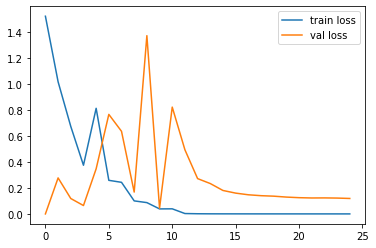

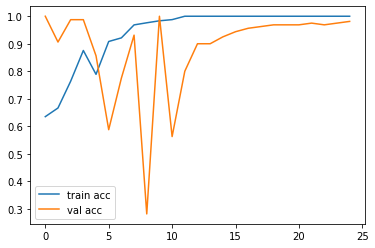

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the trainng and validarion accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [38]:
tf.keras.models.save_model(
    model_finall,
    'model_finall_Shuffle1.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

In [39]:
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2]
